In [41]:
!nvidia-smi

Sat Nov 23 02:25:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:23:00.0 Off |                  Off |
| 35%   56C    P2              85W / 260W |  33156MiB / 49152MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [42]:
#%pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12
#%pip install cucim-cu12 cupy-cuda12x

In [43]:
%pip install fastparquet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [44]:
#%load_ext cudf.pandas

# To desable GPU usage
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#from cucim.skimage.exposure import rescale_intensity
import tensorflow as tf
#import cupy as cp
#import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import gc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # memory limit 16GB (16 * 1024 MB = 16384 MB) 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16384)] 
        )
        print("Set GPU memory limit to 16GB.")
    except RuntimeError as e:
        print("Error setting memory limit:", e)
else:
    print("No GPUs available.")

#print("Is torch using cuda? ",torch.cuda.is_available())
print("Is tensorflow using cuda? ",tf.test.is_built_with_cuda())
print("Is pandas using cuda? ",pd)


Set GPU memory limit to 16GB.
Is tensorflow using cuda?  True
Is pandas using cuda?  <module 'pandas' from '/usr/local/lib/python3.11/dist-packages/pandas/__init__.py'>


In [45]:
name_mapping = [
    "box",
    "circularTorus",
    "cone",
    "coneOffset",
    "cylinder",
    "cylinderSlope",
    "dish",
    "mesh",
    "pyramid",
    "rectangularTorus",
    "sphere"
]

In [46]:
num_classes = 11
def filter_invalid_labels(image, label):
    # Exclude labels that are less than 0 or greater than the maximum allowed class
    valid_labels = tf.reduce_all(label >= 0) & tf.reduce_all(label < num_classes)
    return valid_labels

In [47]:
!ls /home/workspace/geometry-classifier/data/no-stratTF1

test0.tfrecord.gz     train17.tfrecord.gz  train77.tfrecord.gz
test1.tfrecord.gz     train18.tfrecord.gz  train78.tfrecord.gz
test10.tfrecord.gz    train19.tfrecord.gz  train79.tfrecord.gz
test11.tfrecord.gz    train2.tfrecord.gz   train8.tfrecord.gz
test12.tfrecord.gz    train20.tfrecord.gz  train80.tfrecord.gz
test13.tfrecord.gz    train21.tfrecord.gz  train81.tfrecord.gz
test14.tfrecord.gz    train22.tfrecord.gz  train82.tfrecord.gz
test15.tfrecord.gz    train23.tfrecord.gz  train83.tfrecord.gz
test16.tfrecord.gz    train24.tfrecord.gz  train84.tfrecord.gz
test17.tfrecord.gz    train25.tfrecord.gz  train85.tfrecord.gz
test18.tfrecord.gz    train26.tfrecord.gz  train86.tfrecord.gz
test19.tfrecord.gz    train27.tfrecord.gz  train87.tfrecord.gz
test2.tfrecord.gz     train28.tfrecord.gz  train88.tfrecord.gz
test20.tfrecord.gz    train29.tfrecord.gz  train89.tfrecord.gz
test21.tfrecord.gz    train3.tfrecord.gz   train9.tfrecord.gz
test22.tfrecord.gz    train30.tfrecord.gz  train90.tfreco

In [48]:
base_path = '/home/workspace/geometry-classifier/data/'

def parse_tfrecord(example_proto):
    """Parse a single TFRecord example."""
    feature_description = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    name = tf.io.decode_raw(parsed_example['name'], tf.float32)
    image = tf.io.decode_raw(parsed_example['image'], tf.float32)
    image = tf.reshape(image, (224, 224, 1))  # Reshape image data to 224x224x3
    class_label = tf.cast(name[0], tf.int32)  # Use the first byte as a class label
    return image, class_label

def load_tfrecord(tfrecord_files):
    """Load TFRecords and prepare a dataset."""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type="GZIP")
    parsed_dataset = raw_dataset.map(parse_tfrecord)
    return parsed_dataset

# Directory with TFRecords

files_for = lambda file_type: glob.glob(f"{base_path}tfrecord/{file_type}*.tfrecord.gz")

test_files = files_for("test")
validation_files = files_for("val")
train_files = files_for("train")

print(glob.glob(f"{base_path}no-stratTF1/*.tfrecord.gz")[0])

test = load_tfrecord(test_files).filter(filter_invalid_labels)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

train = load_tfrecord(train_files).filter(filter_invalid_labels)
train = train.batch(32).prefetch(tf.data.AUTOTUNE)



/home/workspace/geometry-classifier/data/no-stratTF1/test17.tfrecord.gz


In [49]:
model = tf.keras.models.load_model(base_path+"model1.keras")

In [50]:
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

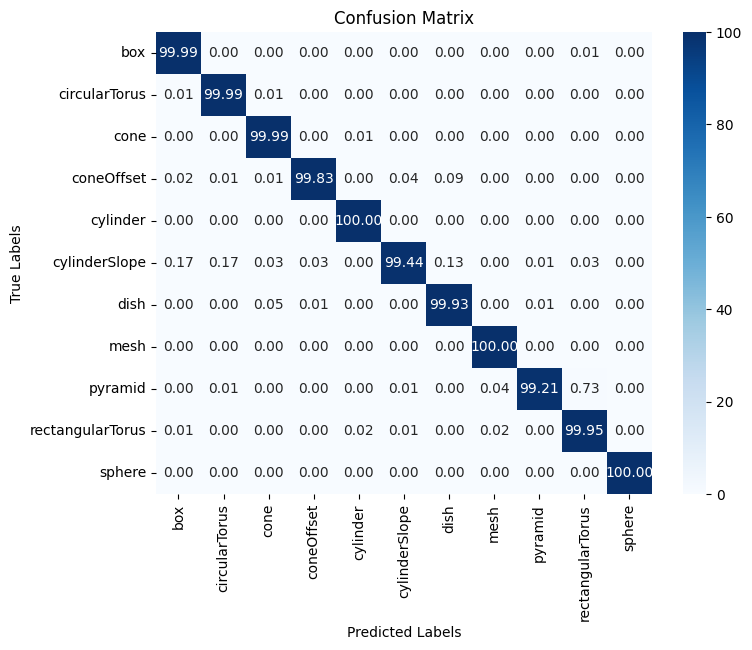

In [51]:

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=name_mapping, yticklabels=name_mapping)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


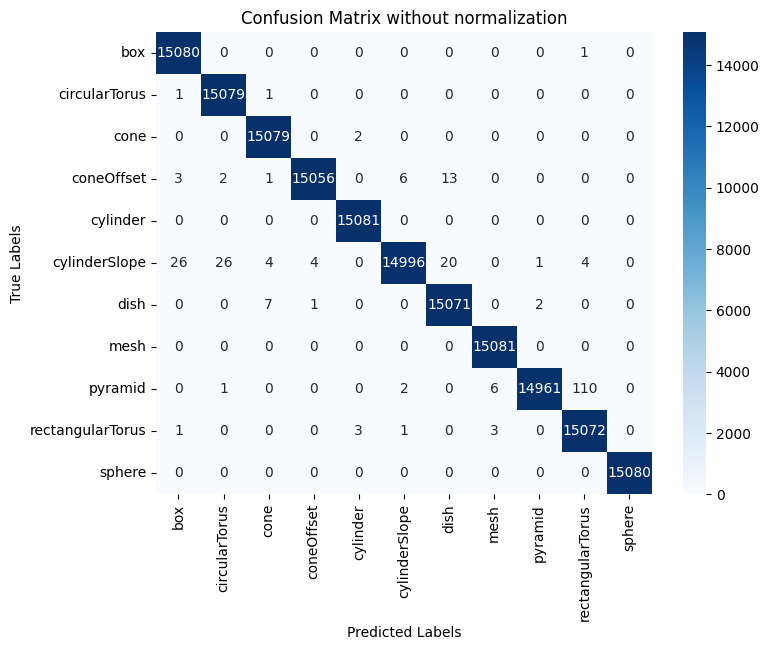

In [52]:

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=name_mapping, yticklabels=name_mapping)
plt.title('Confusion Matrix without normalization')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()